In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

### Custom dataset

In [2]:
cv2.__version__

'3.4.10'

In [3]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode
import glob
from astropy.io import fits

def get_astro_dicts(img_dir):
    
    
    # It's weird to call this img_dir
    #set_dirs = glob.glob('%s/set_*' % img_dir)
    set_dirs = ['%s/set_%d' % (img_dir, i) for i in range(10)]
    
    dataset_dicts = []
    
    # Loop through each set
    for idx, set_dir in enumerate(set_dirs):
        record = {}
        
        mask_dir = os.path.join(img_dir, set_dir, "masks.fits")
        filename = os.path.join(img_dir, set_dir, "img")
        
        # Open each FITS image
        with fits.open(mask_dir, memmap=False, lazy_load_hdus=False) as hdul:
            sources = len(hdul)
            height, width = hdul[0].data.shape
            data = [hdu.data/np.max(hdu.data) for hdu in hdul]
            category_ids = [hdu.header["CLASS_ID"] for hdu in hdul]
            
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []
        
        # Mask value thresholds per category_id
        thresh = [0.005 if i == 1 else 0.08 for i in category_ids]
        
        # Generate segmentation masks
        for i in range(sources):
            image = data[i]
            mask = np.zeros([height, width], dtype=np.uint8)
            # Create mask from threshold
            mask[:,:][image > thresh[i]] = 1
            # Smooth mask
            mask[:,:] = cv2.GaussianBlur(mask[:,:], (9,9), 2)
            
            # https://github.com/facebookresearch/Detectron/issues/100
            mask_new, contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE,
                                                        cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []
            for contour in contours:
                x,y,w,h = cv2.boundingRect(contour)
                contour = contour.flatten().tolist()
                # segmentation.append(contour)
                if len(contour) > 4:
                    segmentation.append(contour)
            # No valid countors
            if len(segmentation) == 0:
                continue
            
            # Add to dict
            obj = {
                "bbox": [x, y, w, h],
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": segmentation,
                "category_id": category_ids[i] - 1,
            }
            objs.append(obj)
            
        record["annotations"] = objs
        dataset_dicts.append(record)
 
    return dataset_dicts

# Register dataset
for d in ["train", "val"]:
    DatasetCatalog.register("astro_" + d, lambda: get_astro_dicts("/home/colinjb2/astro_rcnn/trainingset"))
    MetadataCatalog.get("astro_" + d).set(thing_classes=["star", "galaxy"])
astro_metadata = MetadataCatalog.get("astro_train")

In [4]:
from detectron2.data import build_detection_train_loader

def read_image(filename, normalize='zscore', stretch=5, Q=10, m=0, ceil_percentile=99.995, dtype=np.uint8):
    # Read image
    # TODO: Combine these files into one img_0, mask_0 ... in simulate.py
    g = fits.getdata(os.path.join(filename+'_g.fits.gz'), memmap=False)
    r = fits.getdata(os.path.join(filename+'_r.fits.gz'), memmap=False)
    z = fits.getdata(os.path.join(filename+'_z.fits.gz'), memmap=False)
    
    # Contrast scaling / normalization
    I = (z + r + g)/3.0
    
    length, width = g.shape
    image = np.empty([length, width, 3], dtype=dtype)

    # Options for contrast scaling
    if normalize == 'lupton':
        z = z*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        r = r*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        g = g*np.arcsinh(stretch*Q*(I - m))/(Q*I)
    elif normalize == 'zscore':
        Isigma = I*np.mean([np.std(g),np.std(r),np.std(z)])
        z = (z - np.mean(z) - m)/Isigma
        r = (r - np.mean(r) - m)/Isigma
        g = (g - np.mean(g) - m)/Isigma
    elif normalize == 'linear':
        z = (z - m)/I
        r = (r - m)/I
        g = (g - m)/I

    max_RGB = np.percentile([z,r,g], ceil_percentile)
    # avoid saturation
    r = r/max_RGB; g = g/max_RGB; z = z/max_RGB

    # Rescale to 0-255 for dtype=np.uint8
    r = r*np.iinfo(dtype).max
    g = g*np.iinfo(dtype).max
    z = z*np.iinfo(dtype).max

    # 0-255 BGR image
    image[:,:,0] = g
    image[:,:,1] = r
    image[:,:,2] = z
    
    return image

### Vizualize ground truth

/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


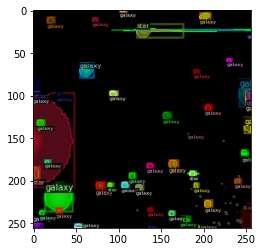

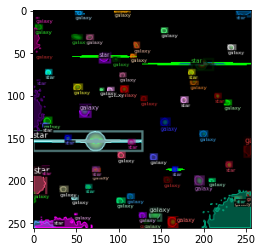

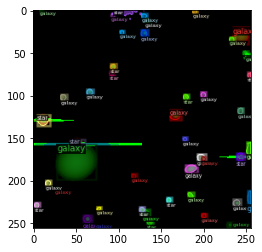

In [5]:
dataset_dicts = get_astro_dicts("/home/colinjb2/astro_rcnn/trainingset")
for d in random.sample(dataset_dicts, 3):
    img = read_image(d["file_name"])
    visualizer = Visualizer(img, metadata=astro_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())
    plt.show()

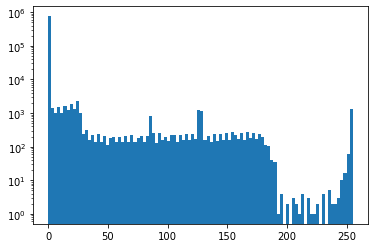

In [6]:
plt.hist(img.flatten(), bins=100);
plt.yscale('log')

### Re-Train

In [8]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("astro_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 

[02/11 17:43:13 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [9]:
# Put custom dataloader here
# FITS dataloader
def astro_mapper(dataset_dict):
    
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    
    image = read_image(dataset_dict["file_name"])

    # Data Augmentation

    return {
       # create the format that the model expects
       "image": image,
       "instances": utils.annotations_to_instances(annos, image.shape[1:])
    }

# TODO: Need to override dataloader in DefaultTrainer
dataloader = build_detection_train_loader(cfg, mapper=astro_mapper)

[02/11 17:43:45 d2.data.build]: Removed 0 images with no usable annotations. 10 images left.
[02/11 17:43:45 d2.data.build]: Using training sampler TrainingSampler
[02/11 17:43:45 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[02/11 17:43:45 d2.data.common]: Serialized dataset takes 0.09 MiB


In [10]:
trainer.resume_or_load(resume=False)
trainer.train()

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[02/11 17:44:01 d2.engine.train_loop]: Starting training from iteration 0
ERROR [02/11 17:44:01 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/detectron2/engine/train_loop.py", line 138, in train
    self.run_step()
  File "/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/detectron2/engine/defaults.py", line 441, in run_step
    self._trainer.run_step()
  File "/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/detectron2/engine/train_loop.py", line 226, in run_step
    data = next(self._data_loader_iter)
  File "/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/detectron2/data/common.py", line 179, in __iter__
    for d in self.dataset:
  File "/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 435, in __next__
    d

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/detectron2/data/common.py", line 43, in __getitem__
    data = self._map_func(self._dataset[cur_idx])
  File "/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/detectron2/utils/serialize.py", line 23, in __call__
    return self._obj(*args, **kwargs)
  File "/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/detectron2/data/dataset_mapper.py", line 125, in __call__
    image = utils.read_image(dataset_dict["file_name"], format=self.image_format)
  File "/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/detectron2/data/detection_utils.py", line 178, in read_image
    with PathManager.open(file_name, "rb") as f:
  File "/home/colinjb2/.local/lib/python3.6/site-packages/iopath/common/file_io.py", line 753, in open
    path, mode, buffering=buffering, **kwargs
  File "/home/colinjb2/.local/lib/python3.6/site-packages/iopath/common/file_io.py", line 429, in _open
    opener=opener,
FileNotFoundError: [Errno 2] No such file or directory: '/home/colinjb2/astro_rcnn/trainingset/set_2/img'


In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

### Inference

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "balloon_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

### Panoptic Segmentation

In [ ]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
plt.imshow(out.get_image()[:, :, ::-1])

### Video 

In [ ]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("ll8TgCZ0plk", width=500)
display(video)

In [ ]:
# Install dependencies, download the video, and crop 5 seconds for processing
!pip install youtube-dl
!pip uninstall -y opencv-python-headless opencv-contrib-python
!apt install python3-opencv  # the one pre-installed have some issues
!youtube-dl https://www.youtube.com/watch?v=ll8TgCZ0plk -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:06 -c:v copy video-clip.mp4

In [ ]:
import cv2

In [ ]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes) with the "demo.py" tool we provided in the repo.
#!git clone https://github.com/facebookresearch/detectron2

# This may not work in jupyter lab environment

# Need to activate modules first
!module load opence
!conda activate opence-v1.1.1-colinjb2
!python detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output video-output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl